# Project 2: Ames Housing Saleprice Prediction

---

#### 02: <b>Preprocessing and Feature Engineering</b>

### Contents:
- [Imports and functions](#Library-and-data-import)
- [Feature Selection & Engineering](#Feature-Selection-&-Feature-Engineering)
- [Recursive Feature Elimination](#Recursive-Feature-Elimination)
- [Transform Saleprice](#Transform-saleprice)
- [Export](#Export)

## Library and data import

In [1]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, RepeatedKFold
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

In [2]:
# import data
train_cleaned = pd.read_csv('../datasets/train_cleaned.csv')
train_final = train_cleaned.copy()
pd.set_option('display.max_columns', 200)

## Functions for Feature Selection and Feature Engineering

In [3]:
# function to drop columns from dataframe
def drop_cols(df, columns):
    df.drop(columns= columns, inplace = True)

# function to identify % of zeros
def pct_zero(df):
    for col in df.columns:
        if df[col].dtypes != 'object':
            zero = np.mean(df[col] == 0)
            print('{} - {}%'.format(col, round(zero*100,1)))
            

# creating heatmaps
def plot_heatmap(dataframe):
    plt.figure(figsize = (12,8))
    corr = dataframe.corr()

    # Set up mask to be "True" in the upper triangle.
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    # Generate heatmap
    sns.heatmap(corr, mask = mask, cmap=sns.color_palette("RdBu_r",7),\
                annot=False, fmt=".2f", cbar_kws = {'shrink': 0.5}, square = True,\
               linewidths = 0.1, vmin=-1, vmax = 1)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()

# creating histograms
def subplot_hist(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows *3.5)) 
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column])
        ax[i].set_title(f'{column} distribution',fontsize=14)
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('count', fontsize=12)
        ax[i].grid(False)
    plt.tight_layout()

# creating scatterplots
def subplot_scatter(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.regplot(y=dataframe['saleprice'], x=dataframe[column],ax=ax[i], ci = False, \
                    scatter_kws={'facecolors':'skyblue','edgecolor':'skyblue','s':6},
                    line_kws = {'color':'grey', 'linewidth': 5})
        ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('saleprice', fontsize=12)
        ax[i].grid(False)
    plt.tight_layout()   
    
# get numerical columns
def col_numerical(df): 
    return [col for col in df.columns if df[col].dtype != 'object']

# get string columns
def col_categorical(df):
    return [col for col in df.columns if df[col].dtype == 'object']

# pearson correlation coefficient
def p_corr_coef(df,columns):
    for col in columns:
        corr,_ = pearsonr(x = df[col], y = train_final['saleprice'])
        print(f'Pearson correlation coeff for {col} is: {round(corr,3)}')

# to find Near Zero Variance features
def near_zer_var(df,lst):
    for features in lst:
        print(df[features].value_counts())
        pct_near_zer = round(((df[features].value_counts().values[0])/\
                 (df[features].value_counts().sum())),2) * 100
        print(f'Percentage of one value: {pct_near_zer}%')
        
# convert ordinal category numerical
def map_new_vals(df,col, dictionary):
    df[col] = df[col].map(dictionary)

## Feature Selection & Feature Engineering
---

Based on the EDA and Exploratory Visualizations done in `1_EDA_and_cleaning` notebook, we will be removing features deemed irrelevant to our regression model for predicting housing prices. Subsequently, we will combine existing columns and conduct feature transformation.

### Feature selection for Numerical columns:
---

First, we will drop the two observation identifiers (i.e. `ID` and `PID`) as they would have no effect on saleprice.

Next, we will drop features that have > 90% of values that are zeros ('0'). These are also known as **near zero variance predictors** (i.e. predictors which have close to only one value) and are considered to have less predictive power.

In [4]:
# drop id and pid columns
columns = ['id','pid']
drop_cols(train_final, columns)

In [5]:
# drop near zero variance predictors
pct_zero(train_final)
columns = ['low_qual_fin_sf','bsmt_half_bath','3ssn_porch','screen_porch',
          'pool_area','misc_val']
drop_cols(train_final, columns)

ms_subclass - 0.0%
lot_frontage - 0.0%
lot_area - 0.0%
overall_qual - 0.0%
overall_cond - 0.0%
year_built - 0.0%
year_remod/add - 0.0%
mas_vnr_area - 59.2%
bsmtfin_sf_1 - 32.0%
bsmtfin_sf_2 - 87.9%
bsmt_unf_sf - 8.1%
total_bsmt_sf - 2.7%
1st_flr_sf - 0.0%
2nd_flr_sf - 58.0%
low_qual_fin_sf - 98.4%
gr_liv_area - 0.0%
bsmt_full_bath - 58.6%
bsmt_half_bath - 93.8%
full_bath - 0.4%
half_bath - 63.7%
bedroom_abvgr - 0.2%
kitchen_abvgr - 0.1%
totrms_abvgrd - 0.0%
fireplaces - 48.7%
garage_yr_blt - 5.6%
garage_cars - 5.6%
garage_area - 5.6%
wood_deck_sf - 52.4%
open_porch_sf - 44.4%
enclosed_porch - 84.0%
3ssn_porch - 98.7%
screen_porch - 91.2%
pool_area - 99.6%
misc_val - 96.8%
mo_sold - 0.0%
yr_sold - 0.0%
saleprice - 0.0%


We will now proceed to examine in greater detail on features that were determined to be collinear when plotting the heatmap during our Exploratory Visualization. 

#### Collinearity between features:

- `lot_area` and <s>`lot_frontage`</s>
- `year_remod/add` and <s>`year_built`</s>
- <s>`1st_flr_sf`</s> and `total_bsmt_sf`
- `gr_liv_area` and <s>`2nd_flr_sf`</s>
- <s>`bsmt_full_bath`</s> and `bsmtfin_sf_1`
- <s>`totrms_abvgrd`</s> and `gr_liv_area`
- <s>`totrms_abvgrd`</s> and `bedroom_abvgr`
- `garage_area` and <s>`garage_cars`</s>

### `lot_area` and `lot_frontage`

Since 330 NaN values of `lot_frontage` were derived from Linear Regression Iterative Imputer that had considered `lot_area` and `lot_cong`, it is within expectation that `lot_area` would be collinear with `lot_frontage`.

However, based on EDA conducted earlier, we have deduced that **area** would be an important predictor and hence we will be removing `lot_frontage`.

In [6]:
# drop lot_frontage
drop_cols(train_final, ['lot_frontage'])

### `year_remod/add` and `year_built`

Based on the data description, `year_remod/add` would have the same value as `year_built` if no remodeling or additions have been done.

Hence, we will remove `year_built` since it is a subset of `year_remod/add`.

However, we will not be dropping it now as we would still require values from `year_built` for further analysis with other features.

### `1st_flr_sf`, `2nd_flr_sf` and `gr_liv_area`

Upon further inspection, when combining columns `1st_flr_sf` and `2nd_flr_sf`, we would get a 99% positive correlation with `gr_liv_area`.

Hence, we will remove `1st_flr_sf` and `2nd_flr_sf`.

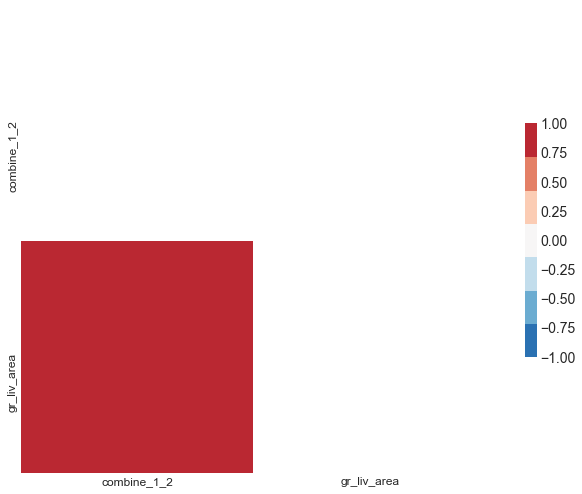

In [7]:
# combining 1st_flr_sf and 2nd_flr_sf to see relation with gr_liv_are
train_final['combine_1_2'] = train_final['1st_flr_sf'] + train_final['2nd_flr_sf']
plot_heatmap(train_final[['combine_1_2','gr_liv_area']])

# drop all columns except gr_liv_area
drop_cols(train_final, ['1st_flr_sf','2nd_flr_sf', 'combine_1_2'])

### `bsmt_full_bath` and `bsmtfin_sf_1`

Given that in **1_EDA_and_cleaning** we have determined that `bsmtfin_sf_1` has a relatively strong linear relationsip with `saleprice` and is an **area** feature which will be an important predictor. We will therefore remove `bsmt_full_bath`.

In [8]:
# drop bsmt_full_bath
drop_cols(train_final, ['bsmt_full_bath'])

### `garage_area` and `garage_cars`

These 2 columns practically mean the same thing but using different metrics in measuring the size of the garage (i.e. square feet vs. car capacity). Hence, we will be keeping `garage_area` since it is a more measurable metric (i.e. square feet)

In [9]:
# drop garage_cars
drop_cols(train_final, ['garage_cars'])

### `totrms_abvgrd` and `gr_liv_area`

In [10]:
# drop totrms_abvgrd as we have decided to keep gr_liv_area
drop_cols(train_final, ['totrms_abvgrd'])

### Further analysis on basement square feet

Namely:   `bsmtfin_sf_1`, `bsmtfin_sf_2`, `bsmt_unf_sf` and `total_bsmt_sf`

Based on data description:

    - BsmtFin SF 1 (Continuous): Type 1 finished square feet
    - BsmtFin SF 2 (Continuous): Type 2 finished square feet
    - Bsmt Unf SF (Continuous): Unfinished square feet of basement area
    - Total Bsmt SF (Continuous): Total square feet of basement area
    
Hence, in theory, <u>total finished sf + total unfinished sf = total sf</u>

In [11]:
# to find out if "total finished sf + total unfinished sf = total sf"
train_final['remainder_sf'] = (train_final['bsmtfin_sf_1']+ train_final['bsmtfin_sf_2']\
+ train_final['bsmt_unf_sf']) - train_final['total_bsmt_sf']
train_final['remainder_sf'].sum()

0.0

In [12]:
# to find the pearson correlation for the 4 columns in question
columns = ['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf']
p_corr_coef(train_final, columns)

Pearson correlation coeff for bsmtfin_sf_1 is: 0.424
Pearson correlation coeff for bsmtfin_sf_2 is: 0.017
Pearson correlation coeff for bsmt_unf_sf is: 0.191
Pearson correlation coeff for total_bsmt_sf is: 0.629


Since <u>total finished sf + total unfinished sf = total sf</u> and `total_bsmt_sf` has the highest pearson correlation, we will keep the column and drop the other 3 columns.

In [13]:
# drop the 3 columns as mentioned above
drop_cols(train_final, ['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf', 'remainder_sf'])

### Visualise remaining numerical columns: 
---
Outliers observed from scatter plots below:

    - lot_area
    - total_bsmt_sf
    - gr_liv_area

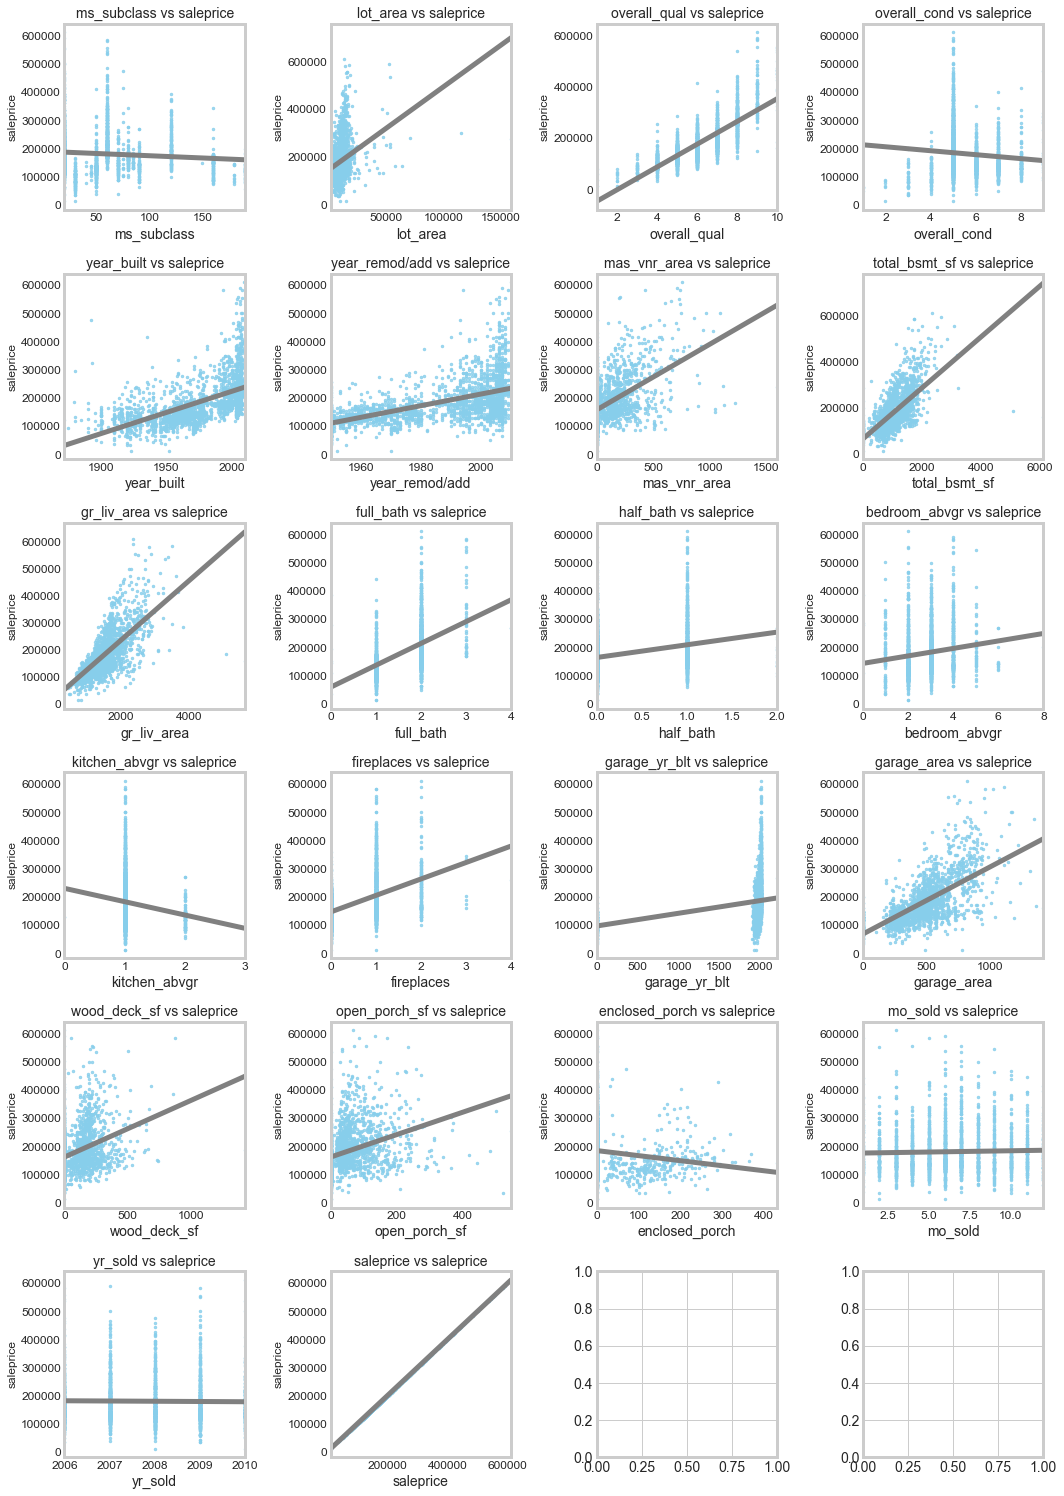

In [14]:
# plot scatter plots to observe relations with saleprice
subplot_scatter(train_final,col_numerical(train_final))

In [15]:
# remove outliers
display(train_final[(train_final['total_bsmt_sf'] > 6000)])
display(train_final[(train_final['lot_area'] > 150_000)])
display(train_final[(train_final['gr_liv_area'] > 5500)])
train_final.drop([471,959], inplace = True)

,ms_subclass,ms_zoning,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,pool_qc,fence,misc_feature,mo_sold,yr_sold,sale_type,saleprice
959,60,RL,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,6110.0,GasA,Ex,Y,SBrkr,5642,2,1,3,1,Ex,Typ,3,Gd,Attchd,2008.0,Fin,1418.0,TA,TA,Y,214,292,0,Gd,None,None,1,2008,New,160000


,ms_subclass,ms_zoning,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,pool_qc,fence,misc_feature,mo_sold,yr_sold,sale_type,saleprice
471,50,RL,159000,Pave,None,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,Unf,1444.0,GasA,Gd,Y,SBrkr,2144,2,0,4,1,Gd,Typ,2,TA,Attchd,1958.0,Fin,389.0,TA,TA,Y,0,98,0,None,None,Shed,6,2007,WD,277000


,ms_subclass,ms_zoning,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,pool_qc,fence,misc_feature,mo_sold,yr_sold,sale_type,saleprice
959,60,RL,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,6110.0,GasA,Ex,Y,SBrkr,5642,2,1,3,1,Ex,Typ,3,Gd,Attchd,2008.0,Fin,1418.0,TA,TA,Y,214,292,0,Gd,None,None,1,2008,New,160000


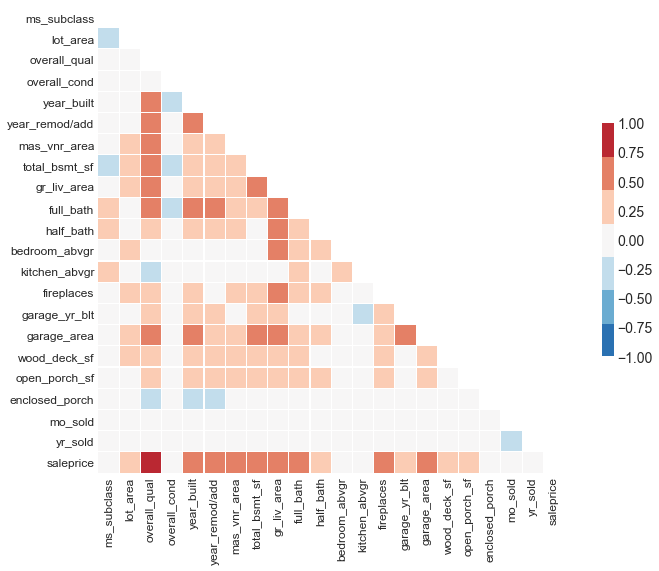

saleprice         1.000000
overall_qual      0.802443
gr_liv_area       0.711344
garage_area       0.654607
total_bsmt_sf     0.651041
year_built        0.572437
year_remod/add    0.550147
full_bath         0.537950
mas_vnr_area      0.512690
fireplaces        0.473323
open_porch_sf     0.336345
lot_area          0.334166
Name: saleprice, dtype: float64

In [16]:
# plot heatmap to find correlations
plot_heatmap(train_final)
train_final.corr()['saleprice'].sort_values(ascending = False).head(12)

We observe that when removing the two outliers above, our correlation for `gr_liv_area` with target has increased from **0.698** to **0.711**, our correlation for `total_bsmt_sf` has increased from **0.629** to **0.651** and **0.297** to **0.334** for that of `lot_area`.

---



Removing Near Zero Variance (> 90% of data consisting of **only one value**) features observed in histograms below:

    - kitchen_abvgr

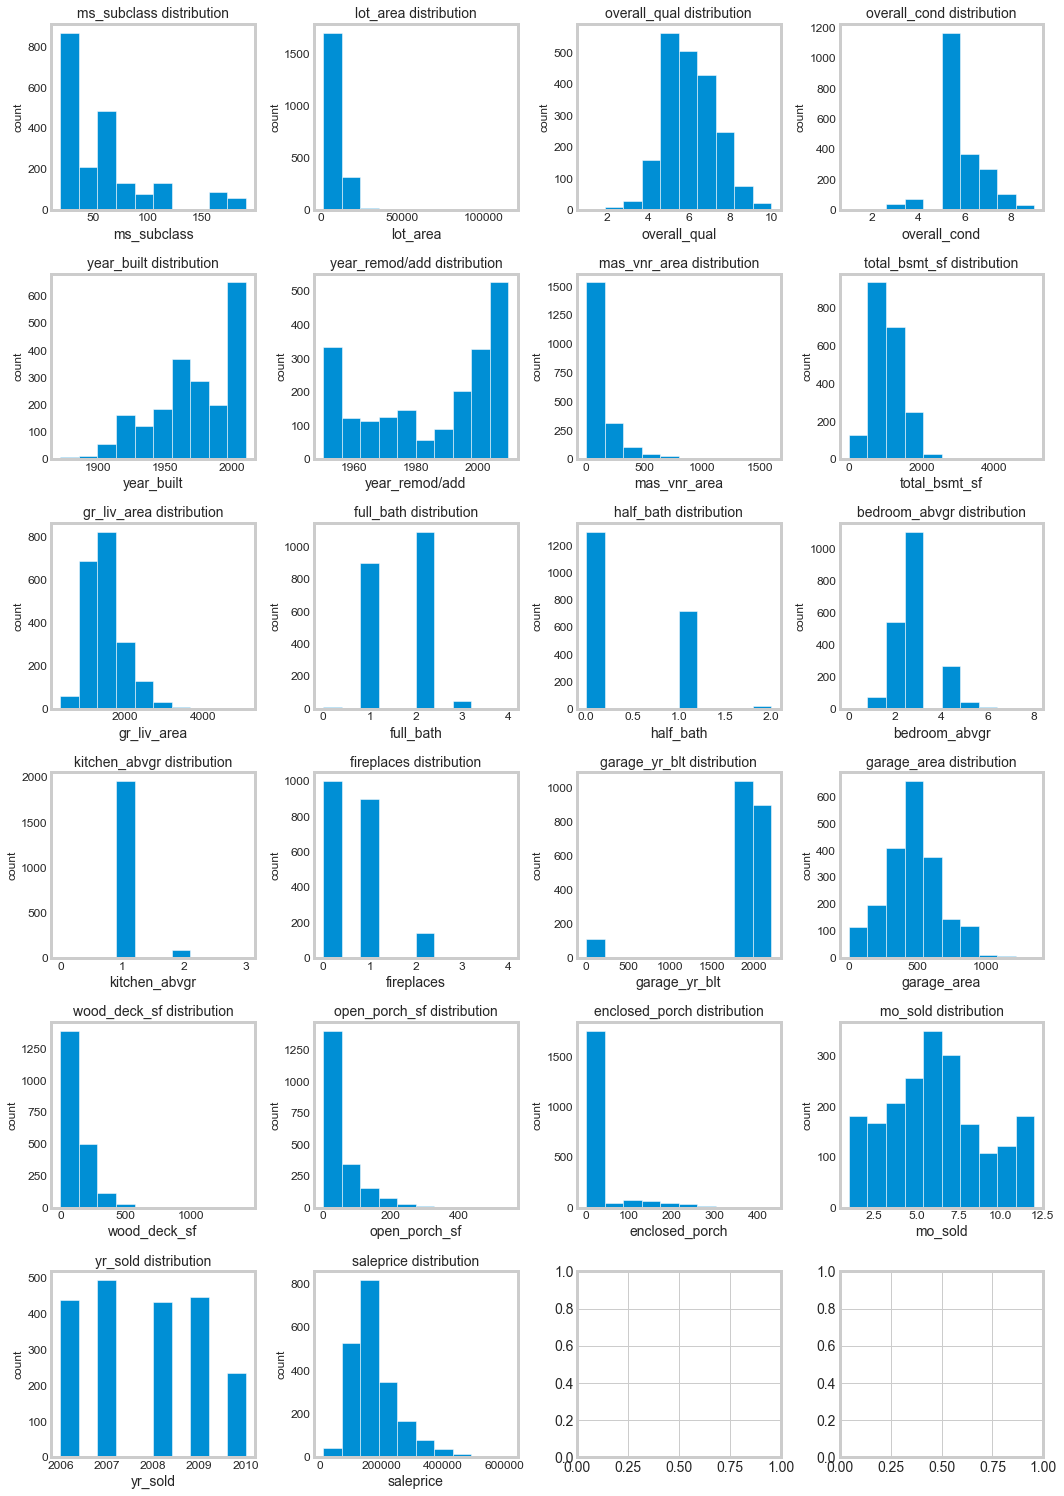

In [17]:
# plot histogram to observe distributions
subplot_hist(train_final,col_numerical(train_final))

In [18]:
# based on histograms above, we have identified 3 features to consider
lst_to_consider = ['lot_area','kitchen_abvgr','enclosed_porch']
near_zer_var(train_final,lst_to_consider)

9600     34
7200     27
6000     26
10800    19
7500     18
         ..
8765      1
10337     1
7614      1
7315      1
7558      1
Name: lot_area, Length: 1471, dtype: int64
Percentage of one value: 2.0%
1    1955
2      88
0       2
3       1
Name: kitchen_abvgr, dtype: int64
Percentage of one value: 96.0%
0      1719
112      13
96       10
40        6
216       6
       ... 
50        1
26        1
109       1
239       1
67        1
Name: enclosed_porch, Length: 159, dtype: int64
Percentage of one value: 84.0%


In [19]:
#drop near zero variance predictor
drop_cols(train_final, ['kitchen_abvgr'])

In [20]:
# viewing remaining numeric features to proceed to feature engineering
number_data = train_final.select_dtypes('number')
number_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 0 to 2047
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ms_subclass     2046 non-null   int64  
 1   lot_area        2046 non-null   int64  
 2   overall_qual    2046 non-null   int64  
 3   overall_cond    2046 non-null   int64  
 4   year_built      2046 non-null   int64  
 5   year_remod/add  2046 non-null   int64  
 6   mas_vnr_area    2046 non-null   float64
 7   total_bsmt_sf   2046 non-null   float64
 8   gr_liv_area     2046 non-null   int64  
 9   full_bath       2046 non-null   int64  
 10  half_bath       2046 non-null   int64  
 11  bedroom_abvgr   2046 non-null   int64  
 12  fireplaces      2046 non-null   int64  
 13  garage_yr_blt   2046 non-null   float64
 14  garage_area     2046 non-null   float64
 15  wood_deck_sf    2046 non-null   int64  
 16  open_porch_sf   2046 non-null   int64  
 17  enclosed_porch  2046 non-null   i

### Feature engineering for Numerical columns:

---

### Change `year_remod/add` and `yr_sold` to `house_sold_age`

As the model cannot distinguish between year & numeric feature, `year_remod/add` and `yr_sold` cannot be used directly and hence we will convert the feature to an **age** feature called `house_sold_age`.

In [21]:
# find the latest year where the house was remodelled / sold
# as this could be the year where the data timeframe stops
print(train_final['year_remod/add'].max())
print(train_final['yr_sold'].max())

2010
2010


In [22]:
# create new age feature
train_final['house_sold_age'] = train_final['yr_sold'] - train_final['year_remod/add']

In [23]:
# checks indicate 2 houses were remodelled after they were sold
house_year = ['house_sold_age','year_built','year_remod/add','yr_sold']
display(train_final[house_year].sort_values(by=['house_sold_age']).head())

# we will remove 1 observation as year sold cannot be earlier than year built
train_final.drop(1882, inplace = True)

# we will modify index 1716's to become year remodelled = year built
train_final.loc[1716,'year_remod/add'] = 2007

# edit new feature and run sanity check again
train_final['house_sold_age'] = train_final['yr_sold'] - train_final['year_remod/add']
display(train_final[house_year].sort_values(by=['house_sold_age']).head())

,house_sold_age,year_built,year_remod/add,yr_sold
1882,-2,2008,2009,2007
1716,-1,2007,2008,2007
1024,0,2007,2007,2007
198,0,2007,2007,2007
1557,0,2006,2006,2006


,house_sold_age,year_built,year_remod/add,yr_sold
1024,0,2007,2007,2007
1520,0,1971,2009,2009
1509,0,2006,2007,2007
1500,0,2006,2007,2007
220,0,2005,2006,2006


In [24]:
# drop year_remod/add, yr_sold and year_built
drop_cols(train_final,['year_remod/add','yr_sold', 'year_built'])

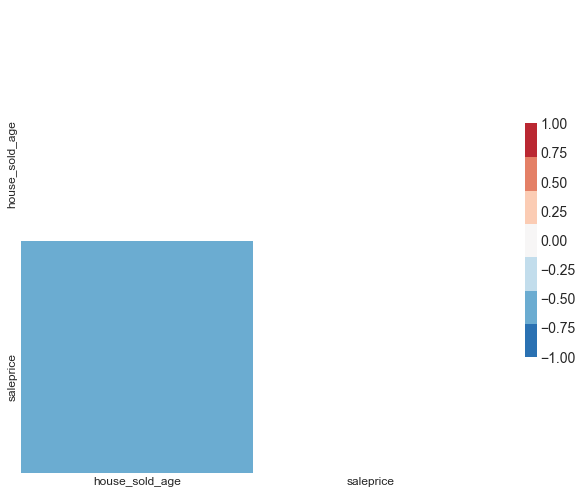

In [25]:
# visualise relation of new feature with target
plot_heatmap(train_final[['house_sold_age','saleprice']])

### Change `garage_yr_blt` to ` garage_age`

Similarly for garage_yr_blt, the model cannot distinguish between year & numeric feature

In [26]:
# noted that one observation was recorded wrongly, hence we will manually change this error
train_final[['garage_yr_blt']].sort_values(by=['garage_yr_blt'],ascending = False).head()

,garage_yr_blt
1696,2207.0
1238,2010.0
144,2010.0
1793,2009.0
962,2009.0


In [27]:
# changing year from 2207 to 2007 as it's the most logical value
train_final.loc[1696,'garage_yr_blt'] = 2007

# find the latest year where the house was remodelled
# as this could be the year where the data timeframe stops, similar to house remodelled
train_final['garage_yr_blt'].max()

2010.0

In [28]:
# create new age feature
train_final['garage_age'] = 2010 - train_final['garage_yr_blt']

# drop garage_yr_blt
drop_cols(train_final,['garage_yr_blt'])

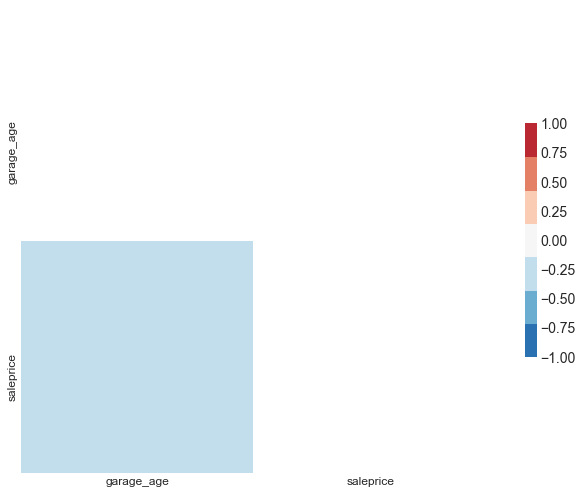

In [29]:
# visualise relation of new feature with target
plot_heatmap(train_final[['garage_age','saleprice']])

### Convert `mo_sold` from numeric to ordinal numeric feature

We are doing this to find out the relation of seasonal change to mean sale price of the house. We are using the mean given that `mo_sold` and `saleprice` both closely resembles a normal distribution.

In [30]:
# convert numerical to nominal
train_final['mo_sold'] = train_final['mo_sold'].astype(str)

# # using groupby method
display(train_final.groupby('mo_sold', as_index = True)['saleprice'].mean().sort_values())

# dictionary of ordinal values
ordinal_values = {'4':0, '3':1, '10':1, '2':1, '5':2, '6':2, '12':2, '11':2, '8':3,\
                  '7':3, '9':3, '1':4}

# mapping
map_new_vals(train_final,'mo_sold',dictionary=ordinal_values)

# sanity checks
train_final['mo_sold'].head(7)

mo_sold
4     163901.269231
3     174625.779762
10    177539.586777
2     177626.519231
5     180332.369650
6     182205.648571
12    182459.615385
11    184377.495146
8     187008.246988
7     188571.514851
9     188990.761468
1     195576.641026
Name: saleprice, dtype: float64

0    1
1    0
2    4
3    0
4    1
5    2
6    2
Name: mo_sold, dtype: int64

### Convert `ms_subclass` from numeric to nominal categorical feature

Based on data description , `ms_subclass` should be nominal instead of discrete.

However, when finding correlation with `saleprice`, noted that none of the ms_subclass values have a strong relation with saleprice. Hence, propose to **drop feature as a whole**.

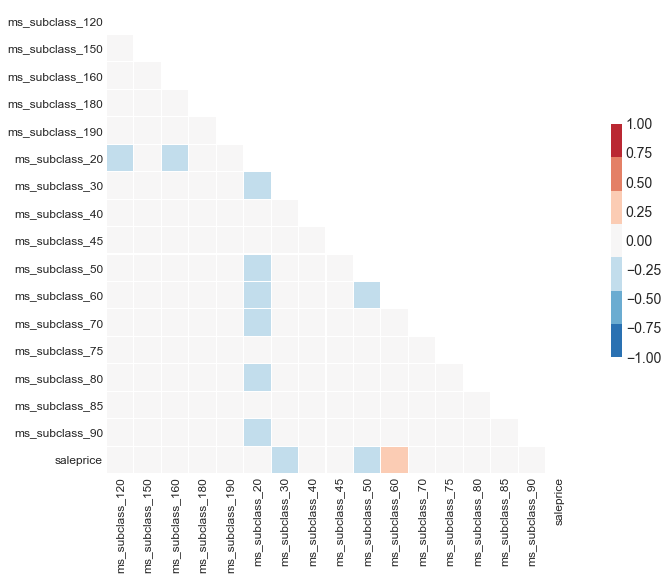

In [31]:
# convert numerical to nominal
train_final['ms_subclass'] = train_final['ms_subclass'].astype(str)

# One hot encode ms_subclass
ms_sub_dummy = pd.get_dummies(data = train_final, columns = ['ms_subclass'])
# concat with sale price to plot relation
ms_sub_dummy = pd.concat( objs = [ ms_sub_dummy.loc[:,'ms_subclass_120':], train_final[['saleprice']] ], axis = 1)

# plot heatmap
plot_heatmap(ms_sub_dummy)

In [32]:
# drop ms_subclass from train_final
drop_cols(train_final, ['ms_subclass'])

### Feature selection for Categorical columns:

---

Similar to numerical columns, we will drop categorical features that have > 90% containing only the same value. These are also known as **near zero variance predictors** (i.e. predictors which have close to only one value) and are considered to have less predictive power.

In [33]:
# find which features are near zero predictors
near_zer_var(train_final, col_categorical(train_final))

RL         1592
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64
Percentage of one value: 78.0%
Pave    2038
Grvl       7
Name: street, dtype: int64
Percentage of one value: 100.0%
None    1905
Grvl      85
Pave      55
Name: alley, dtype: int64
Percentage of one value: 93.0%
Reg    1292
IR1     691
IR2      54
IR3       8
Name: lot_shape, dtype: int64
Percentage of one value: 63.0%
Lvl    1841
HLS      84
Bnk      78
Low      42
Name: land_contour, dtype: int64
Percentage of one value: 90.0%
AllPub    2043
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64
Percentage of one value: 100.0%
Inside     1499
Corner      347
CulDSac     130
FR2          60
FR3           9
Name: lot_config, dtype: int64
Percentage of one value: 73.0%
Gtl    1948
Mod      88
Sev       9
Name: land_slope, dtype: int64
Percentage of one value: 95.0%
NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    129
Nri

Below are the features that we will be dropping. Why we dropped them will be based on 2 factors:

    1. Near zero variance
    2. How important it is in affecting sale price

In [34]:
# drop columns
cols = ['street','utilities','land_slope','condition_2','roof_matl','heating',\
       'central_air','electrical','pool_qc']
drop_cols(train_final, cols)

# we will also drop 'sale_type' as does not address our problem statement
drop_cols(train_final, ['sale_type'])

### Feature engineering for Categorical columns:

---

In [35]:
# reset index of dataframe first
train_final.reset_index(inplace = True)
drop_cols(train_final,['index'])

### Binarize  `exterior_2nd`

Based on the data description, the value of `exterior_2nd` would be the same as `exterior_1st` if the house has only one material used for exterior covering. Hence, propose to binarize feature to `exterior_2nd_present`, where '1' would indicate a 2nd material present and '0' otherwise.

In [36]:
# binarize feature
for index, val in enumerate(train_final['exterior_2nd']):
    if val == train_final.loc[index,'exterior_1st']:
        train_final.loc[index, 'exterior_2nd_present'] = 0
    else:
        train_final.loc[index, 'exterior_2nd_present'] = 1

In [37]:
# drop old feature
drop_cols(train_final, ['exterior_2nd'])

## Further analysis on `exterior_1st`

Looking as there is weak correlation of `exterior_1st` with `saleprice`, it is safe to say that material used for exterior covering would be an irrelevant feature. Hence, propose to drop.

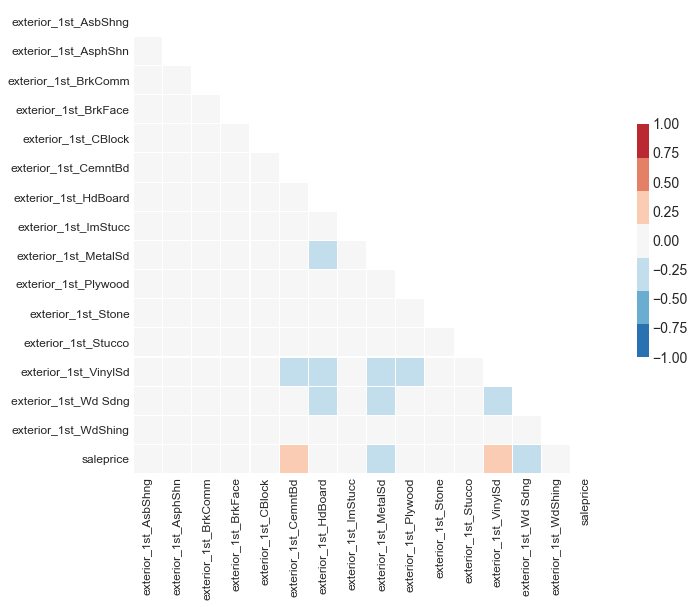

In [38]:
# One hot encode ms_subclass
ext_1st_dummy = pd.get_dummies(data = train_final, columns = ['exterior_1st'])

# concat with sale price to plot relation
ext_1st_dummy = pd.concat( objs = [ ext_1st_dummy.loc[:,'exterior_1st_AsbShng':], train_final[['saleprice']] ], axis = 1)

# # # plot heatmap
plot_heatmap(ext_1st_dummy)

In [39]:
# drop ms_subclass from train_final
drop_cols(train_final, ['exterior_1st'])

### Binarize  `alley` and `paved_drive`

For `alley`, propose setting '1' as alley access present and '0' alley access absent.

For `paved_drive`, propose setting '1' as paved/partial pavement present and '0' for pavement absent.

In [40]:
# binarize alley feature
binary_dict = {'Grvl':1, 'Pave':1, 'None':0}
train_final['alley_present'] = train_final['alley'].map(binary_dict)

In [41]:
# binarize paved drive features
binary_dict = {'Y':1, 'P':1, 'N':0}
train_final['paved_drive_present'] = train_final['paved_drive'].map(binary_dict)

In [42]:
# drop old features
drop_cols(train_final, ['alley','paved_drive'])

### Encode `ordinal` variables

In [43]:
# split remaining objects into ordinal and nominal 
ord_cols = ['lot_shape','exter_qual','exter_cond','bsmt_qual','bsmt_cond','bsmt_exposure',\
           'bsmtfin_type_1','bsmtfin_type_2','heating_qc','kitchen_qual','fireplace_qu',\
           'garage_finish','garage_qual','garage_cond','fence','neighborhood']
nom_cols = ['ms_zoning','land_contour','lot_config','condition_1',\
           'bldg_type','house_style','roof_style','mas_vnr_type','foundation',\
            'functional','garage_type','misc_feature']

In [44]:
# defining dictionaries to convert ordinal to numerical

lotshape = {'Reg': 0,
            'IR1': 1,
            'IR2': 2,
            'IR3': 3}

qual_cond = {'Ex': 5,
             'Gd': 4,
             'TA': 3,
             'Fa': 2,
             'Po': 1,
             'None': 0}

bsmtexposure = {'None': 0,
                'No': 1,
                'Mn': 2,
                'Av': 3,
                'Gd': 4}

bsmtfintype = {'GLQ': 6,
              'ALQ': 5,
              'BLQ': 4,
              'Rec': 3,
              'LwQ': 2,
              'Unf': 1,
              'None': 0}

garagefinish = {'Fin': 3,
               'RFn': 2,
               'Unf': 1,
               'None': 0}

fence = {'GdPrv': 4,
        'GdWo': 3,
        'MnPrv': 2,
        'MnWw': 1,
        'None': 0}

In [45]:
# map new values using function defined at the very beginning
map_new_vals(train_final, 'lot_shape', lotshape)
map_new_vals(train_final, 'exter_qual', qual_cond)
map_new_vals(train_final, 'exter_cond', qual_cond)
map_new_vals(train_final, 'bsmt_qual', qual_cond)
map_new_vals(train_final, 'bsmt_cond', qual_cond)
map_new_vals(train_final, 'bsmt_exposure', bsmtexposure)
map_new_vals(train_final, 'bsmtfin_type_1', bsmtfintype)
map_new_vals(train_final, 'bsmtfin_type_2', bsmtfintype)
map_new_vals(train_final, 'heating_qc', qual_cond)
map_new_vals(train_final, 'kitchen_qual', qual_cond)
map_new_vals(train_final, 'fireplace_qu', qual_cond)
map_new_vals(train_final, 'garage_finish', garagefinish)
map_new_vals(train_final, 'garage_qual', qual_cond)
map_new_vals(train_final, 'garage_cond', qual_cond)
map_new_vals(train_final, 'fence', fence)


Based on Exploratory Visualizations done in `1_EDA_and_cleaning`, the box plot for `neighborhood` indicated the different neighborhood values are highly stratified (indicated by varied medians). Hence, propose to encode as ordinal variable.

In [46]:
# order of neighborhood in relation to saleprice
print(train_final.groupby('neighborhood', as_index=True)['saleprice'].mean().sort_values(ascending=True).round(2))

neighborhood
MeadowV    100231.25
IDOTRR     101103.19
BrDale     103371.05
OldTown    125276.30
BrkSide    127022.70
Edwards    129905.79
SWISU      134758.88
Landmrk    137000.00
Sawyer     137181.91
NPkVill    140476.47
Blueste    144566.67
NAmes      145905.82
Mitchel    167656.71
SawyerW    187760.16
Greens     188666.67
Gilbert    189365.16
NWAmes     194619.02
Blmngtn    200417.68
CollgCr    202497.22
Crawfor    205901.21
ClearCr    215201.23
Somerst    227019.99
Timber     241051.35
Veenker    253570.59
GrnHill    280000.00
NoRidge    316294.12
NridgHt    322831.35
StoneBr    327991.30
Name: saleprice, dtype: float64


In [47]:
# defining dictionaries to convert ordinal to numerical
neighbor = {'MeadowV': 0,
              'IDOTRR': 0,
              'BrDale': 0,
              'OldTown': 0,
              'BrkSide': 0,
              'Edwards': 0,
              'SWISU': 0,
              'Landmrk': 0,
              'Sawyer': 0,
              'NPkVill': 0,
              'Blueste': 0,
              'NAmes': 0,
              'Mitchel': 1,
              'SawyerW': 1,
              'Greens': 1,
              'Gilbert': 1,
              'NWAmes': 1,
              'Blmngtn': 2,
              'CollgCr': 2,
              'Crawfor': 2,
              'ClearCr': 2,
              'Somerst': 2,
              'Timber': 3,
              'Veenker': 3,
              'GrnHill': 3,
              'NoRidge': 4,
              'NridgHt': 4,
              'StoneBr': 4}

# map new values using function defined at the very beginning
map_new_vals(train_final, 'neighborhood', neighbor)

### Categorical columns

## Encode `nominal` variables
---
We will <u>one hot encode</u> the rest of our nominal variable features as they generally do not have any form of rank or order.

In [48]:
train_final_dummy = pd.get_dummies(data = train_final, columns = nom_cols, drop_first = True)

In [49]:
train_final_dummy.shape

(2045, 100)

## Recursive Feature Elimination
---

After doing feature selection and feature engineering, we will be introducing our first automated feature selection method: `recursive feature eliminiation` (RFE). This would further reduce the existing 100 columns (after One-Hot encoding has been done to nominal variables), given that we only have observations close to 2000. 

RFE is a feature selection algorithm that fits a model and removes the weakest feature(s) until the specified number of features is reached. In this particular instance, we train the algorithm on our data and let it rank features by their coefficient attribute (note: these are the coefficients of the features with respect to the model). The least important coefficient is thus dropped from the current list of features (i.e. 100) and the model adopt the remaining set of features.

After experimentation, we found that the ideal number of features to use would be 75 as it gives the best balance between number of features and MAE value.

In [50]:
# get all features in dataframe as 'input'. There should be 154 features excld. saleprice
features = [col for col in train_final_dummy._get_numeric_data().columns if col !='saleprice']
X = train_final_dummy[features]
y = train_final_dummy['saleprice']

In [51]:
# choosing the ideal no. of features to use for our model
for i in range(70,81):
    model = LinearRegression()
    rfe = RFE(estimator = model, n_features_to_select = i)
    cv = RepeatedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
    score = cross_val_score(rfe, X,y, scoring = 'neg_mean_absolute_error', cv=cv, error_score='raise')
    print(f'MAE for {i} no. of features: {-round(np.mean(score),2)}')

MAE for 70 no. of features: 23831.86
MAE for 71 no. of features: 23821.24
MAE for 72 no. of features: 23781.36
MAE for 73 no. of features: 23773.75
MAE for 74 no. of features: 23782.12
MAE for 75 no. of features: 23778.55
MAE for 76 no. of features: 23801.65
MAE for 77 no. of features: 23803.19
MAE for 78 no. of features: 23808.41
MAE for 79 no. of features: 23800.06
MAE for 80 no. of features: 23807.11


In [52]:
# find out which features rank the worst and we shall drop the worst 5 features
rfe = RFE(model, n_features_to_select = 75)
rfe_fit = rfe.fit(X,y)
rfe_df = pd.DataFrame(columns=['Feature', 'Ranking'])
rfe_df['Feature'] = X.columns
rfe_df['Ranking'] = rfe_fit.ranking_

In [53]:
rfe_df.sort_values(by='Ranking', ascending=False).head(30)

,Feature,Ranking
0,lot_area,25
26,wood_deck_sf,24
27,open_porch_sf,23
46,lot_config_FR2,22
32,garage_age,21
31,house_sold_age,20
28,enclosed_porch,19
1,lot_shape,18
13,total_bsmt_sf,17
23,garage_area,16


In [54]:
X.columns[~rfe_fit.get_support()].tolist()

['lot_area',
 'lot_shape',
 'mas_vnr_area',
 'bsmtfin_type_2',
 'total_bsmt_sf',
 'heating_qc',
 'gr_liv_area',
 'fireplace_qu',
 'garage_area',
 'garage_cond',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 'fence',
 'house_sold_age',
 'garage_age',
 'alley_present',
 'lot_config_FR2',
 'lot_config_Inside',
 'house_style_1Story',
 'foundation_PConc',
 'garage_type_CarPort',
 'misc_feature_Shed',
 'misc_feature_TenC']

In [55]:
# create a list features above to be investigated before dropping
rfe_list = X.columns[~rfe_fit.get_support()]
rfe_list_saleprice = ['lot_area','lot_shape','mas_vnr_area','bsmtfin_type_2',
                      'total_bsmt_sf','heating_qc','gr_liv_area','fireplace_qu',
                      'garage_area','garage_cond','wood_deck_sf','open_porch_sf',
                      'enclosed_porch','fence','house_sold_age','garage_age',
                      'alley_present','lot_config_FR2','lot_config_Inside',
                      'house_style_1Story','foundation_PConc','garage_type_CarPort',
                      'misc_feature_Shed','misc_feature_TenC', 'saleprice']

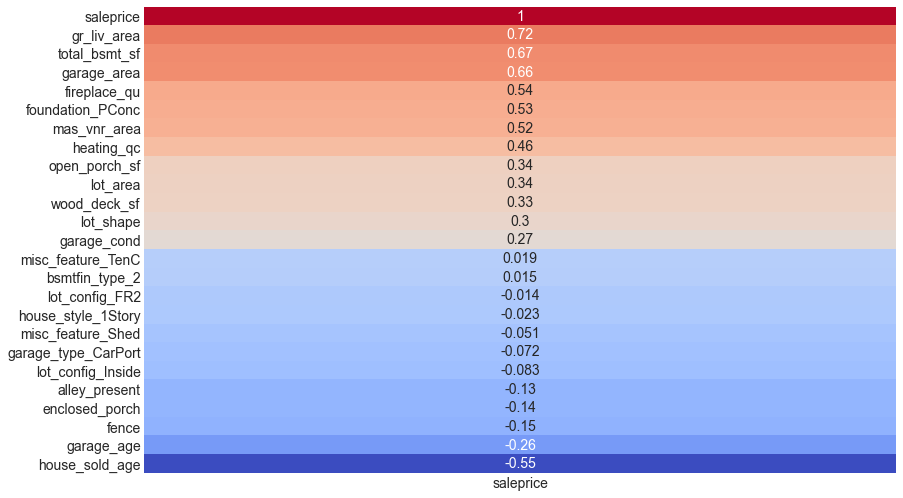

In [56]:
# plot heatmap to visualise correlation between saleprice and features
plt.figure(figsize = (12,8))
sns.heatmap(train_final_dummy[rfe_list_saleprice].corr()[['saleprice']].sort_values(by='saleprice', ascending = False), cmap='coolwarm', annot=True, cbar= False)
plt.show()

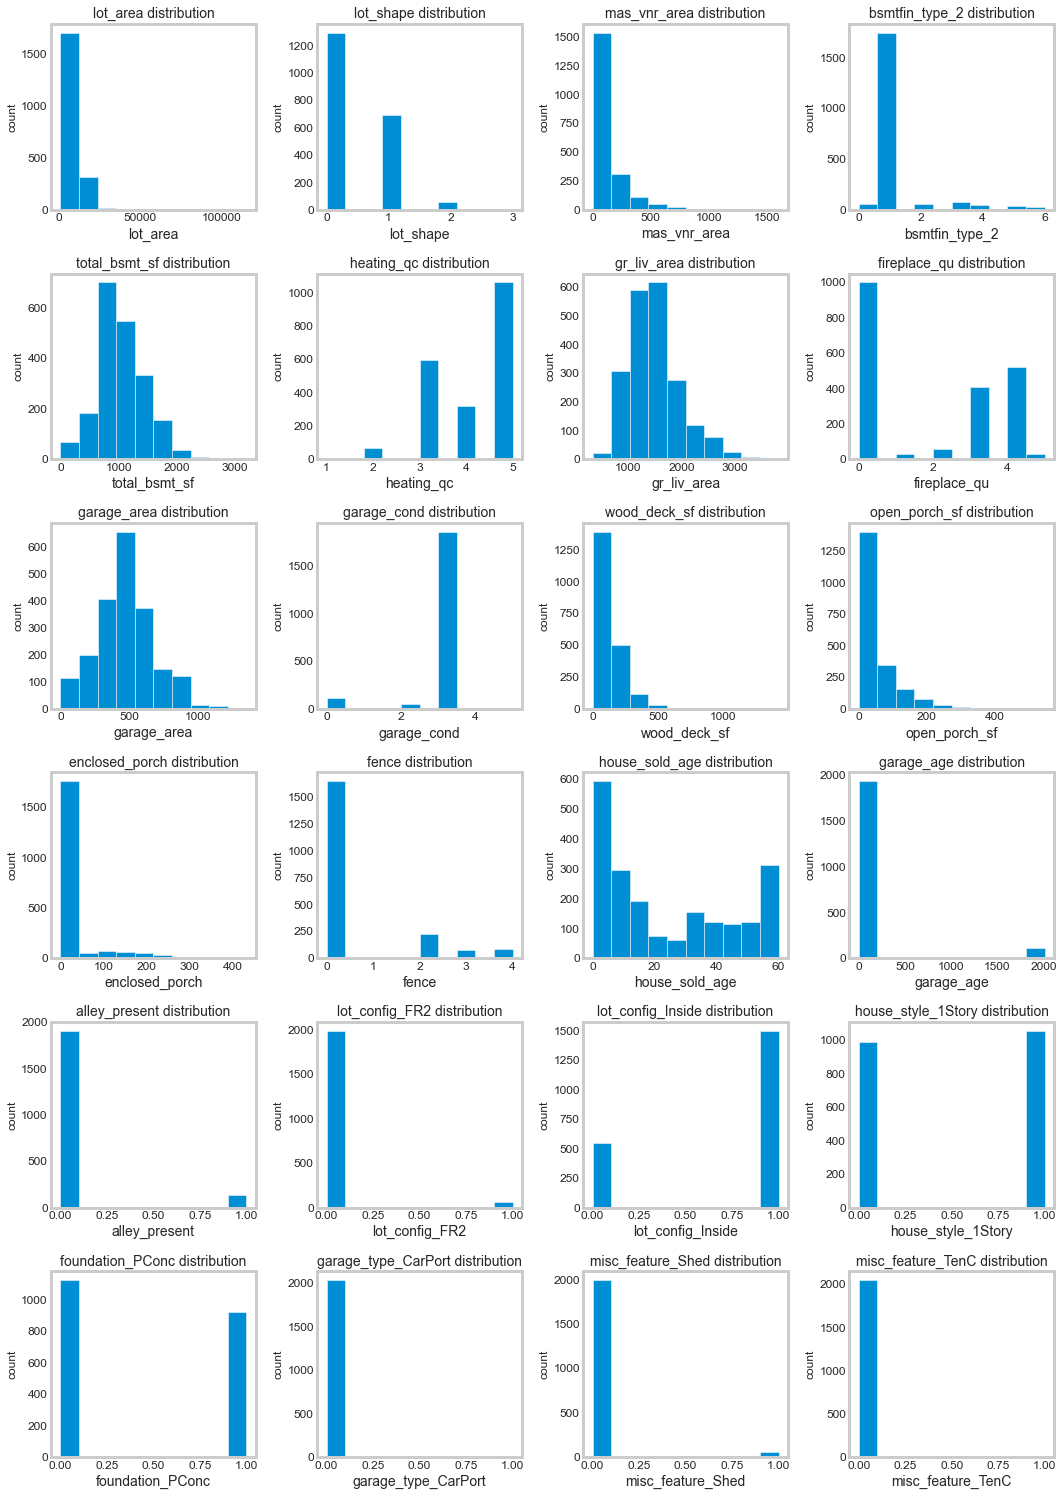

In [57]:
subplot_hist(train_final_dummy, rfe_list)

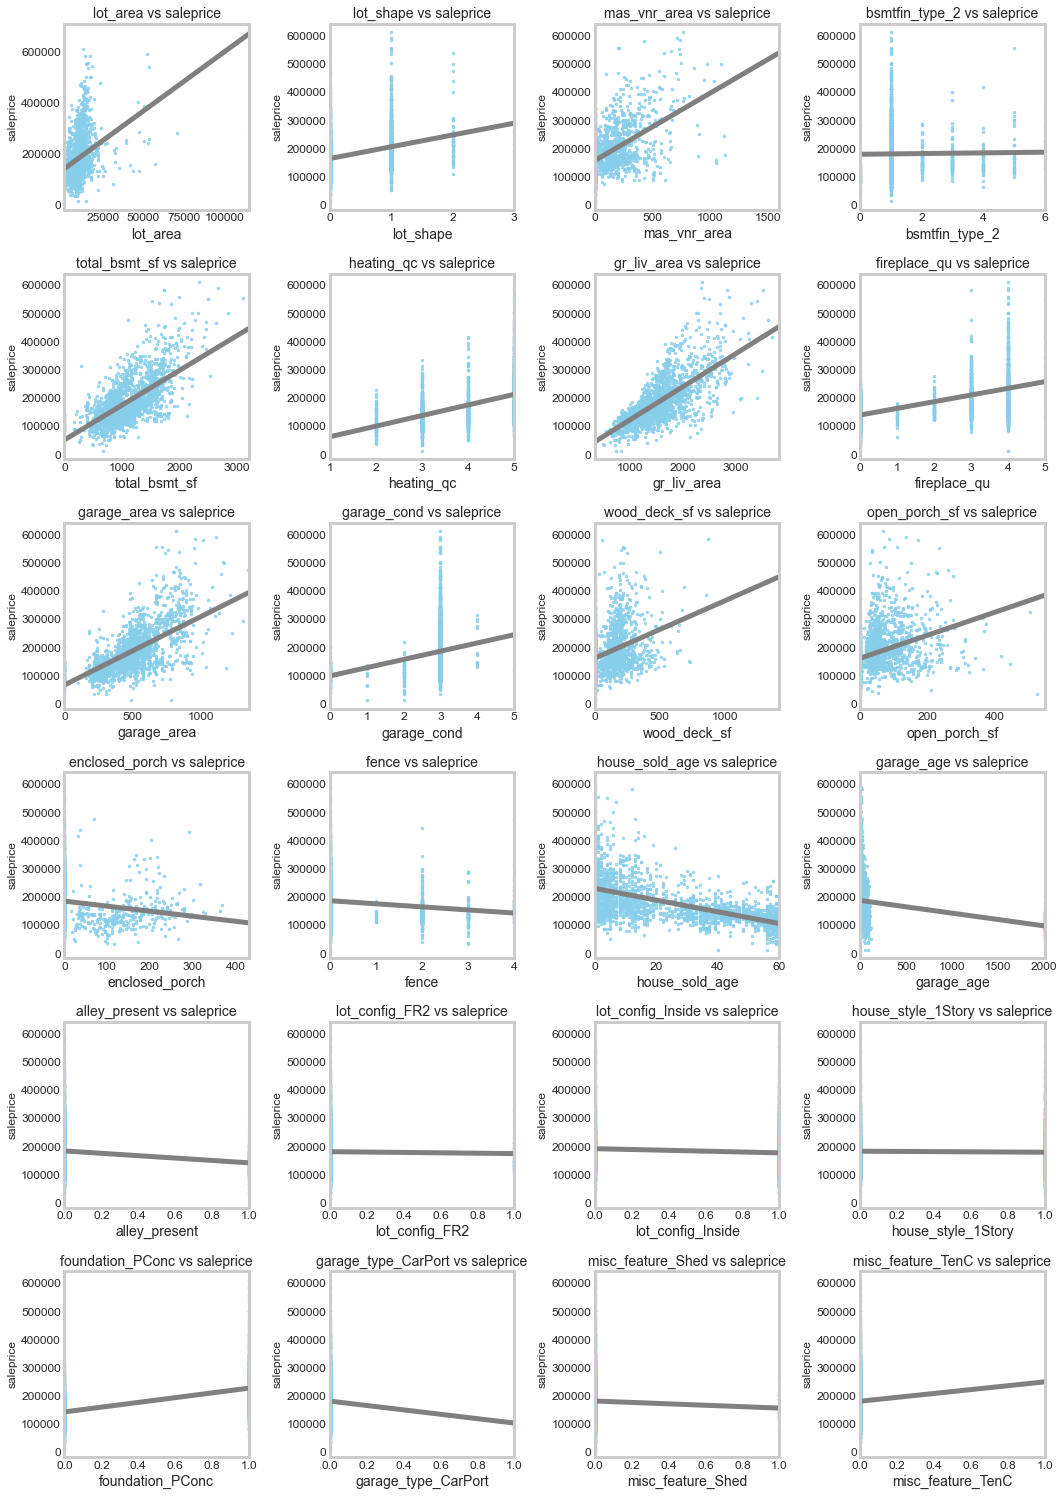

In [58]:
subplot_scatter(train_final_dummy, rfe_list)

Based on the above analysis, we will drop the features based on a few factors:

    1. Features are weakly correlated to saleprice
    2. Features must not be derived from OHE

In [59]:
# list of features to drop
list_to_drop = ['heating_qc','open_porch_sf','lot_area','wood_deck_sf','lot_shape','garage_cond',
                'bsmtfin_type_2','alley_present','enclosed_porch','fence','garage_age']

# drop cols
drop_cols(train_final_dummy, list_to_drop)

## Transform Saleprice
- Coverting saleprice to log(saleprice)

Given the high variance of saleprice as shown below, taking the log of saleprice and plotting it against its independent variables would rescale the coefficients into a normal distribution curve. This effectively changes the range of the data into a natural logarithm.

By applying the logarithm to saleprice, there is a much more distinguished and or adjusted linear regression line through the base of the data points, resulting in a better prediction model


**(example only) Before Log:**
![](../pictures/before_log.png)


**(example only) After Log:**
![](../pictures/after_log.png)


In [60]:
# view variances for each feature after OHE
for name, value in enumerate(train_final_dummy.var().round(2)):
    print(train_final_dummy.var().round(2).index[name], float(value))

neighborhood 1.72
overall_qual 2.02
overall_cond 1.22
mas_vnr_area 29433.59
exter_qual 0.34
exter_cond 0.14
bsmt_qual 0.81
bsmt_cond 0.33
bsmt_exposure 1.16
bsmtfin_type_1 4.52
total_bsmt_sf 182170.05
gr_liv_area 236192.93
full_bath 0.3
half_bath 0.25
bedroom_abvgr 0.68
kitchen_qual 0.44
fireplaces 0.4
fireplace_qu 3.26
garage_finish 0.81
garage_area 46066.54
garage_qual 0.52
mo_sold 1.03
saleprice 6271751085.53
house_sold_age 441.5
exterior_2nd_present 0.13
paved_drive_present 0.07
ms_zoning_C (all) 0.01
ms_zoning_FV 0.05
ms_zoning_I (all) 0.0
ms_zoning_RH 0.01
ms_zoning_RL 0.17
ms_zoning_RM 0.13
land_contour_HLS 0.04
land_contour_Low 0.02
land_contour_Lvl 0.09
lot_config_CulDSac 0.06
lot_config_FR2 0.03
lot_config_FR3 0.0
lot_config_Inside 0.2
condition_1_Feedr 0.05
condition_1_Norm 0.12
condition_1_PosA 0.01
condition_1_PosN 0.01
condition_1_RRAe 0.01
condition_1_RRAn 0.02
condition_1_RRNe 0.0
condition_1_RRNn 0.0
bldg_type_2fmCon 0.02
bldg_type_Duplex 0.04
bldg_type_Twnhs 0.03
bldg

In [61]:
# log saleprice
train_final_dummy['saleprice'] = np.log(train_final_dummy['saleprice'])

In [62]:
train_final_dummy.shape

(2045, 89)

## Export 
---

In [63]:
# export final version in csv
train_final_dummy.to_csv('../datasets/train_final_dummy.csv', index = False)